In [1]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.transform import downscale_local_mean, rotate
import numpy as np
import os
import tifffile
from scipy import ndimage
import time
import torch
from torch.utils.data import Dataset, DataLoader
#import dataloader1 as dataloader
import dataloader_SRCNN as dataloader
import cv2
import skimage
import model_SRCNN
from patchify import patchify, unpatchify


D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {device_count}")
    for i in range(device_count):
        device = torch.cuda.get_device_name(i)
        print(f"Device {i}: {device}")
else:
    print("CUDA is not available on this machine.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is not available on this machine.


In [3]:
patch_size = 64
batch_size = 1

In [4]:
path_d = 'data/02_Substack (6267-6662)_B40_bag12_13.tif'
path_t = 'data/registered_image02_3dCT_B40_bag12_13_300mm.tif'
data = tifffile.imread(path_d)[:70,:,:]
target = tifffile.imread(path_t)[:70,:,:]

print ('Data initial shape = ',data.shape)
print ('Target initial shape = ',data.shape)

Data initial shape =  (70, 1786, 1798)
Target initial shape =  (70, 1786, 1798)


In [5]:
def contrast_stretching(img):
    # Contrast stretching
    # Dropping extreems (artifacts)
    batch = 32
    print ('performed on a batch of = ', batch)
    for i in range ((img.shape[0]//batch)+1):
        if (i+1)*batch <img.shape[0]:
            input_image = img[i*batch:(i+1)*batch]
            p2, p98 = np.percentile(input_image, (2, 98))
            img[i*batch:(i+1)*batch] = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))
        else:
            input_image = img[i*batch:]
            p2, p98 = np.percentile(input_image, (2, 98))
            img[i*batch:] = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))
        print(f"Progress: {round(((i+1)*batch)*100/img.shape[0])} %", end='\r')
    return img


def reshape_to_power_of_2(data):
    # Check if the shape of the image in each dimension is a power of 2
    original_shape = data.shape
    new_shape = [2**int(np.ceil(np.log2(dim))) for dim in data.shape]
    padding = [(0, new_dim - old_dim) for old_dim, new_dim in zip(data.shape, new_shape)]
    data = np.pad(data, padding, mode='constant', constant_values=0)
    print ('original_shape =',original_shape)
    print ('padding = ',padding)
    return original_shape, padding, data

def patchyfy_img(img, ps, step):
    padded_shape = img.shape
    img = patchify(img,(ps, ps, ps) ,  step=step )
    patched_shape = img.shape
    img = img.reshape(img.shape[0]*img.shape[1]*img.shape[2],ps,ps,ps )
    return padded_shape, patched_shape,img

def build_original_image(img,patched_shape, padded_shape, original_shape, padding):
    img = img.reshape(patched_shape)
    print (img.shape)
    img = unpatchify(img, padded_shape)
    print (img.shape)
    img = img[:img.shape[0]-padding[0][1], :img.shape[1]-padding[1][1], :img.shape[2]-padding[2][1]]
    print (img.shape)
    return img

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    



In [6]:
data = contrast_stretching(data)

performed on a batch of =  32


In [7]:
original_shape, padding , data = reshape_to_power_of_2(data)

original_shape = (70, 1786, 1798)
padding =  [(0, 58), (0, 262), (0, 250)]


In [8]:
padded_shape, patched_shape, data = patchyfy_img(data,ps=patch_size,step=patch_size)

In [9]:
prediction = np.zeros_like(data)
model = model_SRCNN.SRCNN()
load_checkpoint(torch.load("my_SRCNN_checkpoint.pth.tar",map_location=torch.device('cpu') ), model)   

for i in range(data.shape[0]):
    input_= torch.from_numpy(data[i]).unsqueeze(0).unsqueeze(0).float()
    input_ = input_/255 #normalization
    output_= model(input_).cpu().detach().numpy()
    output_ = output_[0,0]*255 # back to real scale
    output_ = output_.astype('uint8')
    prediction[i]=output_
    print(f"Progress: {round(i*100/data.shape[0])} %", end='\r')

    

=> Loading checkpoint


In [10]:
prediction.shape

(2048, 64, 64, 64)

In [11]:
prediction = build_original_image(prediction,patched_shape, padded_shape, original_shape, padding)

(2, 32, 32, 64, 64, 64)
(128, 2048, 2048)
(70, 1786, 1798)


In [12]:
prediction.shape

(70, 1786, 1798)

In [60]:
target = contrast_stretching(target)

performed on a batch of =  32


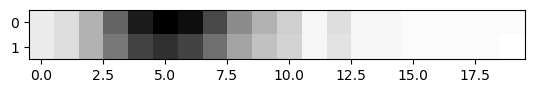

In [69]:
plt.imshow(prediction[10,600:602,500:520],'gray') # [10:16,640:704,64:640]

In [79]:

kernel = 2
preds = patchyfy_img(prediction[10:12,600:602,500:628], kernel,1)[-1]
tars = patchyfy_img(target[10:12,600:602,500:628], kernel,1)[-1]


In [80]:
PSNR = []
for i in range(tars.shape[0]):
    psnr= skimage.metrics.peak_signal_noise_ratio(tars[i], preds[i])
    if psnr != 'inf':
        PSNR.append(psnr)
#PSNR = np.array(PSNR)
#PSNR = PSNR[np.isfinite(PSNR)]

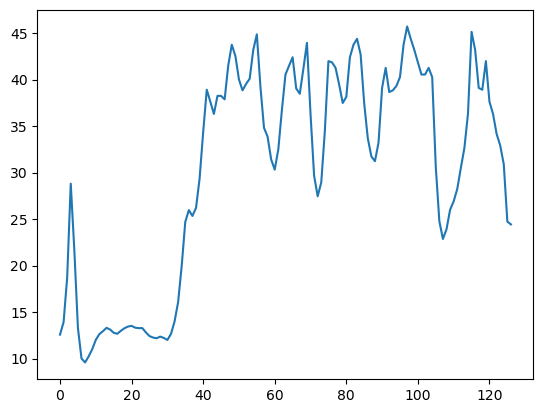

In [81]:
plt.plot(PSNR)